# Modeling - XGBoost Classifier

**Obiettivo:** Classificazione IncidentGrade (TruePositive, BenignPositive, FalsePositive)

**Metrica:** Macro F1-Score

**Pipeline:**
1. Caricamento dati
2. Training XGBoost
3. Valutazione e cross-validation
4. Feature importance
5. Salvataggio modello

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    f1_score,
    accuracy_score
)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('whitegrid')

print("Librerie importate con successo!")

Librerie importate con successo!


## 2. Caricamento Dati

In [2]:
print("Caricamento dataset processati...")

X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')['IncidentGrade']
y_test = pd.read_csv('../data/processed/y_test.csv')['IncidentGrade']

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"\nDistribuzione y_train:\n{y_train.value_counts(normalize=True)}")

Caricamento dataset processati...
X_train: (314230, 22)
X_test: (134671, 22)

Distribuzione y_train:
IncidentGrade
BenignPositive    0.485921
FalsePositive     0.301088
TruePositive      0.212990
Name: proportion, dtype: float64


In [3]:
# Encoding target
le_target = LabelEncoder()
y_train_encoded = le_target.fit_transform(y_train)
y_test_encoded = le_target.transform(y_test)

print("Mapping label:")
for i, label in enumerate(le_target.classes_):
    print(f"  {label} -> {i}")

Mapping label:
  BenignPositive -> 0
  FalsePositive -> 1
  TruePositive -> 2


## 3. Training XGBoost

In [5]:
print("Training XGBoost...\n")

model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(le_target.classes_),
    eval_metric='mlogloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist',
    n_jobs=-1
)

model.fit(
    X_train, y_train_encoded,
    eval_set=[(X_test, y_test_encoded)],
    verbose=True
)

print("Training completato!")

Training XGBoost...

[0]	validation_0-mlogloss:1.01083
[1]	validation_0-mlogloss:0.96891
[2]	validation_0-mlogloss:0.92684
[3]	validation_0-mlogloss:0.89240
[4]	validation_0-mlogloss:0.87013
[5]	validation_0-mlogloss:0.85095
[6]	validation_0-mlogloss:0.82616
[7]	validation_0-mlogloss:0.80172
[8]	validation_0-mlogloss:0.77706
[9]	validation_0-mlogloss:0.76016
[10]	validation_0-mlogloss:0.74214
[11]	validation_0-mlogloss:0.72396
[12]	validation_0-mlogloss:0.71420
[13]	validation_0-mlogloss:0.70043
[14]	validation_0-mlogloss:0.68619
[15]	validation_0-mlogloss:0.67337
[16]	validation_0-mlogloss:0.66165
[17]	validation_0-mlogloss:0.65162
[18]	validation_0-mlogloss:0.64246
[19]	validation_0-mlogloss:0.63418
[20]	validation_0-mlogloss:0.62623
[21]	validation_0-mlogloss:0.62034
[22]	validation_0-mlogloss:0.61364
[23]	validation_0-mlogloss:0.60640
[24]	validation_0-mlogloss:0.60011
[25]	validation_0-mlogloss:0.59557
[26]	validation_0-mlogloss:0.58957
[27]	validation_0-mlogloss:0.58542
[28]	vali

## 4. Valutazione

In [6]:
y_pred = model.predict(X_test)

print("=" * 70)
print("PERFORMANCE TEST SET")
print("=" * 70)

print("\nClassification Report:")
print(classification_report(
    y_test_encoded, y_pred,
    target_names=le_target.classes_,
    digits=4
))

accuracy = accuracy_score(y_test_encoded, y_pred)
macro_f1 = f1_score(y_test_encoded, y_pred, average='macro')

print(f"\nACCURACY:          {accuracy:.4f}")
print(f"MACRO F1-SCORE:    {macro_f1:.4f} ⭐")

PERFORMANCE TEST SET

Classification Report:
                precision    recall  f1-score   support

BenignPositive     0.8399    0.9342    0.8845     65440
 FalsePositive     0.8721    0.8272    0.8490     40547
  TruePositive     0.8692    0.7097    0.7814     28684

      accuracy                         0.8542    134671
     macro avg     0.8604    0.8237    0.8383    134671
  weighted avg     0.8558    0.8542    0.8519    134671


ACCURACY:          0.8542
MACRO F1-SCORE:    0.8383 ⭐


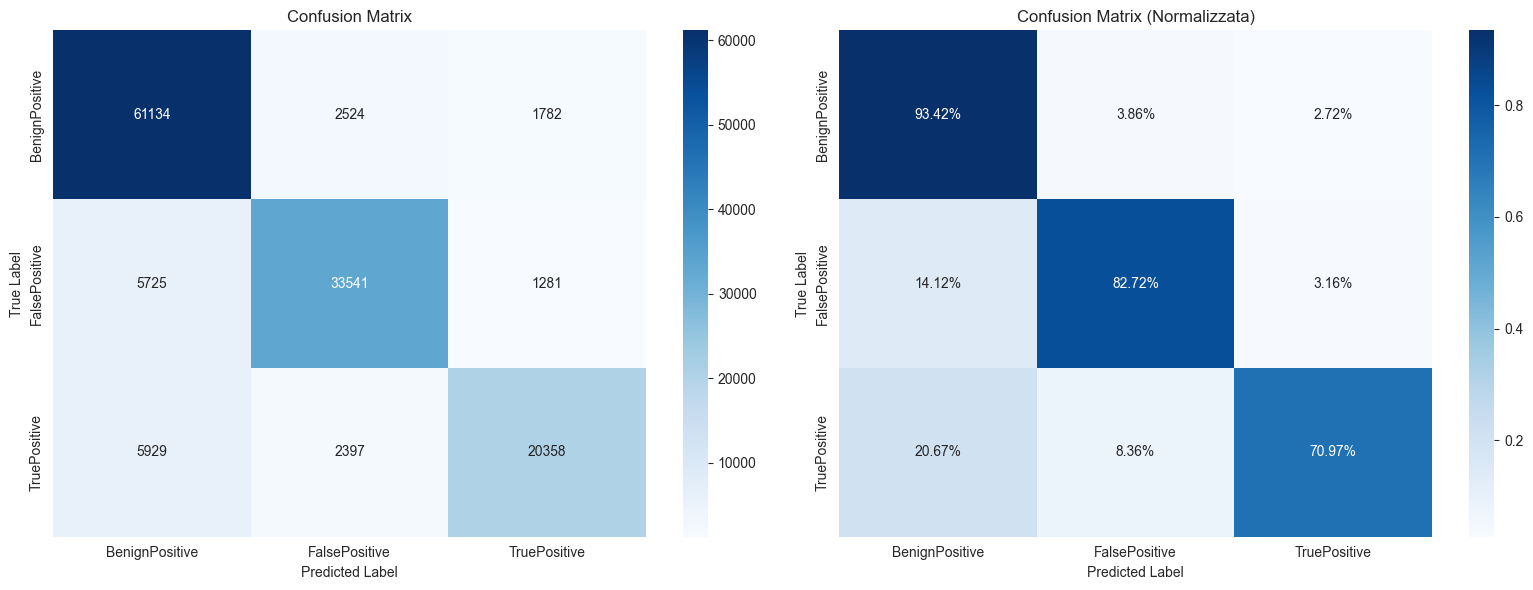

In [7]:
# Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_,
            ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_,
            ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalizzata)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## 5. Cross-Validation

In [8]:
print("Esecuzione 5-Fold Cross-Validation...\n")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    model, X_train, y_train_encoded,
    cv=skf,
    scoring='f1_macro',
    n_jobs=-1
)

print(f"Cross-Validation Macro F1 Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\nMedia:  {cv_scores.mean():.4f}")
print(f"Std:    {cv_scores.std():.4f}")

Esecuzione 5-Fold Cross-Validation...

Cross-Validation Macro F1 Scores:
  Fold 1: 0.8385
  Fold 2: 0.8436
  Fold 3: 0.8395
  Fold 4: 0.8400
  Fold 5: 0.8394

Media:  0.8402
Std:    0.0018


## 6. Feature Importance

In [9]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 20 Features più importanti:")
print(feature_importance.head(20).to_string(index=False))

Top 20 Features più importanti:
            Feature  Importance
        OrgId_first    0.232536
DetectorId_get_mode    0.170325
          NumAlerts    0.121202
       NumEvidences    0.109371
   NumWithSuspicion    0.073218
     NumWithVerdict    0.071945
  Category_get_mode    0.065258
     NumEntityTypes    0.030068
   Duration_seconds    0.026695
          Hour_Last    0.021633
      IsWeekend_max    0.013822
 DayOfWeek_get_mode    0.012057
   NumEvidenceRoles    0.009117
         Hour_First    0.008040
           Hour_Avg    0.007064
  MITRE_unknown_sum    0.004794
    MITRE_T1110_sum    0.004315
    MITRE_T1059_sum    0.004284
    MITRE_T1078_sum    0.003850
    MITRE_T1566_sum    0.003793


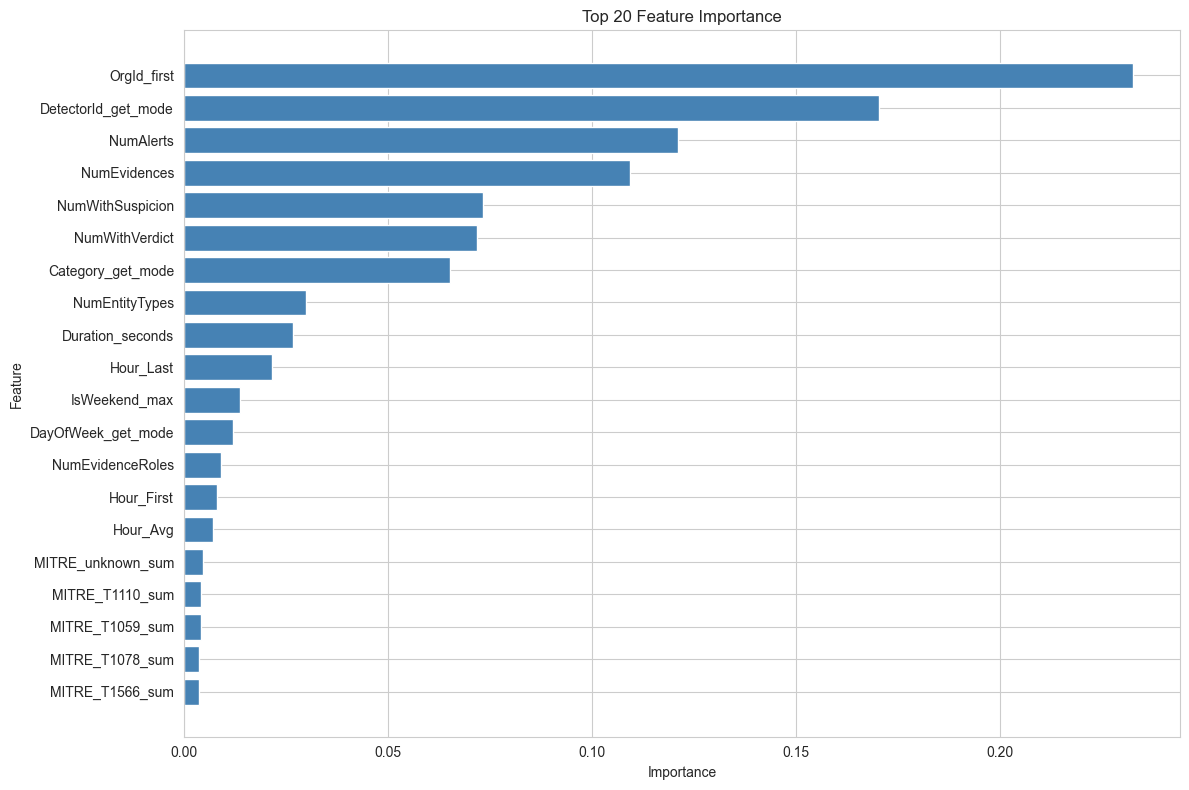

In [10]:
# Plot top features
plt.figure(figsize=(12, 8))
top_n = 20
top_features = feature_importance.head(top_n)

plt.barh(range(top_n), top_features['Importance'], color='steelblue')
plt.yticks(range(top_n), top_features['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Salvataggio Modello

In [11]:
os.makedirs('../models', exist_ok=True)

model.save_model('../models/xgboost_optimized.json')

with open('../models/xgboost_optimized.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('../models/label_encoder_target.pkl', 'wb') as f:
    pickle.dump(le_target, f)

feature_importance.to_csv('../models/feature_importance.csv', index=False)

print("Modello salvato in ../models/")
print("  - xgboost_optimized.json")
print("  - xgboost_optimized.pkl")
print("  - label_encoder_target.pkl")
print("  - feature_importance.csv")

Modello salvato in ../models/
  - xgboost_optimized.json
  - xgboost_optimized.pkl
  - label_encoder_target.pkl
  - feature_importance.csv


## 8. Riepilogo

In [12]:
print("=" * 70)
print("RIEPILOGO FINALE")
print("=" * 70)

print(f"\nDATASET:")
print(f"  Training: {len(X_train):,} samples")
print(f"  Test: {len(X_test):,} samples")
print(f"  Features: {X_train.shape[1]}")
print(f"  Classi: {len(le_target.classes_)} ({', '.join(le_target.classes_)})")

print(f"\nPERFORMANCE:")
print(f"  Test Accuracy: {accuracy:.4f}")
print(f"  Test Macro F1: {macro_f1:.4f}")
print(f"  CV Macro F1: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print(f"\nTOP 5 FEATURES:")
for _, row in feature_importance.head(5).iterrows():
    print(f"  {row['Feature']:30s} {row['Importance']:.4f}")

print("\n" + "=" * 70)

RIEPILOGO FINALE

DATASET:
  Training: 314,230 samples
  Test: 134,671 samples
  Features: 22
  Classi: 3 (BenignPositive, FalsePositive, TruePositive)

PERFORMANCE:
  Test Accuracy: 0.8542
  Test Macro F1: 0.8383
  CV Macro F1: 0.8402 ± 0.0018

TOP 5 FEATURES:
  OrgId_first                    0.2325
  DetectorId_get_mode            0.1703
  NumAlerts                      0.1212
  NumEvidences                   0.1094
  NumWithSuspicion               0.0732

